In [1]:
# IMPORTING MODULES

import sys
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import random
import math
import matplotlib.pyplot as plt 
import plotly.graph_objects as go

In [2]:


#Staring with , we shall first analyse the dataset and decide what to delete
#Firstly , we shall read the dataset
class CleanData:
    def __init__(self):
        #Now we shall read the dataset in this file
        self.old_df = pd.read_csv('zomato.csv')
        #Variable for sampling (10%)
        self.p = 0.01
    #Function for sampling data
    def data_sample(self):
        self.df = pd.read_csv('zomato.csv', header=0, skiprows=lambda i: i>0 and random.random() > self.p)
        return self.df
    #Specialised functions
    def fill_cost(self):
        self.old_df.rename(columns = {'approx_cost(for two people)':'cost'},inplace=True)
        #Now for regression to replace values
        self.old_df['cost'] = self.old_df['cost'].apply(lambda row : str(row))
        self.old_df['cost'] = self.old_df['cost'].apply(lambda row : row.replace(',',''))
        self.old_df['cost'] = self.old_df['cost'].apply(lambda row : float(row))
        rate_na_vals_df = self.old_df[self.old_df['cost'].isna()]
        rate_na_vals = rate_na_vals_df['rest_type'].to_numpy()
        #print(rate_na_vals)
        temp_df = self.old_df.dropna()
        temp_df = temp_df.loc[temp_df['rest_type'].isin(rate_na_vals)]
        X = pd.get_dummies(data=temp_df['rest_type'],drop_first=True)
        #Add the variable
        temp_df = temp_df.join(X)
        temp_df.drop(columns=['rest_type'],inplace=True)
        #Now for proper Linear regression
        Y = pd.DataFrame(temp_df['cost'])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
        regr = linear_model.LinearRegression()
        regr.fit(X_train, Y_train)
        #Only for testing purposes
        #I have used df in memory , but it is not advisable
        rest_type_x = pd.get_dummies(data = rate_na_vals_df['rest_type'],drop_first=True)
        cost_predicted = regr.predict(rest_type_x)
        cost_predicted = cost_predicted.reshape(-1)
        cost_predicted = cost_predicted.astype(float)
        #print(cost_predicted)
        cost_series = pd.Series(cost_predicted)
        #print(df.index[df.isnull().any(axis=1)])
        fill = pd.DataFrame(index=self.old_df.index[self.old_df.isnull().any(axis=1)], data=cost_predicted, columns=['cost'])
        self.old_df = self.old_df.fillna(fill)
    #Here for decoration
    def morph_rest_type(self):
        req_rest_types = ['Quick Bites' , 'Casual Dining' , 'Fine Dining' , 'Bakery' , 'Bar' , 'Food Court' , 'Pub' , 'Microbrewerry']
        #Above shall hold the unique restaraunt types we need (for double restaraunt types only)
        indi_rest_types = self.old_df['rest_type'].unique()
        new_rest_type_dict = {}
        #We shall check if it has a composite type
        for i in indi_rest_types:
            if (',' in i):
                double_type_rest = i.split(',')
                double_type_rest[1].strip(' ')
                #Checking each individual type 
                for j in double_type_rest:
                    if (j in req_rest_types):
                        new_rest_type_dict[i] = j
                        break
                #Since we do not need that many values
            #Thus the above will replace all double values with a single type
            else:
                #If some are individual , just use it as it is
                new_rest_type_dict[i] = i
        #Here we shall replace the entire thing
        self.old_df['rest_type'] = self.old_df['rest_type'].map(new_rest_type_dict)
        #For decorations
    def replace_rate(self):
        rates_list = self.old_df['rate'].to_numpy()
        #Now we shall replace the rates with their averages
        rate_count = 0
        rate_avg = 0
        #We shall replace all missing rating with the average
        #This might be biased but it works in this case
        for i in rates_list:
            if (type(i) == str and not (i == 'NEW')):
                i = i.split('/')
                #For some reason , a '-' comes out of somewhere
                if (not i[0] == '-'):
                    rate_sum_temp = float(i[0])
                    rate_avg += rate_sum_temp
            rate_count += 1
        rate_avg /= rate_count
        rate_avg = round(rate_avg,1)
        #Now we shall replace the DF with the given values
        self.old_df['rate'].fillna(str(rate_avg) + '/5', inplace=True)
        self.old_df[self.old_df['rate'] == 'NEW'].replace(str(rate_avg) + '/5')
    #For decoration
    #Function for cleaning out data
    def clean_data(self):
        self.old_df.dropna(subset=['location','rest_type','cuisines'], inplace=True)
        self.old_df.drop(['phone','dish_liked','url','listed_in(type)','reviews_list'], axis=1, inplace=True)
        #Replacing the rate
        self.replace_rate()
        self.morph_rest_type()
        self.old_df.dropna(subset=['rest_type'],inplace=True)
        self.fill_cost()
        #At the end , we shall save it to CSV again
        self.save_cleaned_file()
    #We need a function to completely clean the data
    #We need to fill the other empty rows also
    #Function for saving as CSV again
    def save_cleaned_file(self):
        self.old_df.to_csv('zomato.csv', sep=',')
#Only for testing shall I use this
#From the printing of the NA we can say
#We do not require the 'favourite-dish' hence we can remove that
#We do not require those restaraunts whose location and type are not present thus we can remove them
#There is no way to fill these values in , hence we are removing them
#Moreover two columns - phone number and dish liked are not possible to fill
#We also do not require URL and listed_in(type)
#Hence we shall remove these two columns entirely as they are not important to the analysis
df = pd.read_csv('zomato.csv')
obj = CleanData()
obj.clean_data()
#Let us consider a set of types we shall allow in the above
#The following are what we shall consider 
#Now we shall try and use regression to impute the missing values
#in the cost for two (approx)

In [3]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


# SUMMARY OF DATASET

In [4]:
print('This dataset contains %d rows and %d columns'%(df.shape[0], df.shape[1]))

This dataset contains 51717 rows and 17 columns


# VISUALIZATIONS

<AxesSubplot:title={'center':'ONLINE ORDERS'}, ylabel='online_order'>

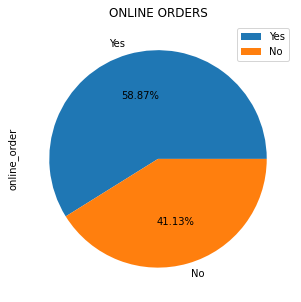

In [5]:
online_orderDF = df['online_order'].value_counts()
online_orderDF = online_orderDF.to_frame()
online_orderDF.plot.pie(y='online_order', figsize=(5,5), autopct='%1.2f%%',title='ONLINE ORDERS')

<AxesSubplot:title={'center':'COMMON TYPES OF RESTAURANTS'}>

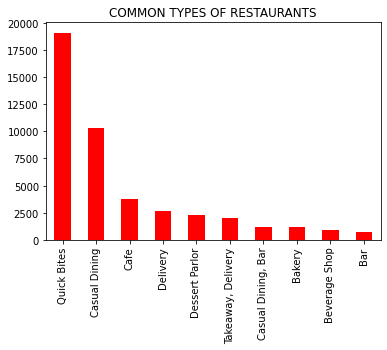

In [6]:
rest_typeDF = df['rest_type'].value_counts().head(10)
rest_typeDF = rest_typeDF.to_frame()
rest_typeDF.plot.bar(y='rest_type', legend=False, title='COMMON TYPES OF RESTAURANTS', color='red')

In [7]:
rest_typeDF = df['rest_type'].value_counts().head(12)
rest_typeDF = rest_typeDF.to_frame()
rest_typeDF = rest_typeDF.sample(frac=1)
type_heading = list(rest_typeDF.index)
count_heading = list(rest_typeDF['rest_type'])

fig = go.Figure()

fig.add_trace(go.Barpolar(
    r=list(count_heading),
    theta=list(type_heading),
    name='C',
    marker_color='rgb(46,109,255)',
    marker_line_color='black',
    hoverinfo=['all'],
    opacity=0.7
))

fig.update_layout(
    title='TYPES OF RESTAURANTS',
    font_size=12,
    legend_font_size=15,
    polar_angularaxis_rotation=90,
    width=600,
    height=600,
    polar=dict(
        bgcolor="rgb(223,223,223)"
    )
)

fig.show()

<AxesSubplot:title={'center':'RATINGS'}>

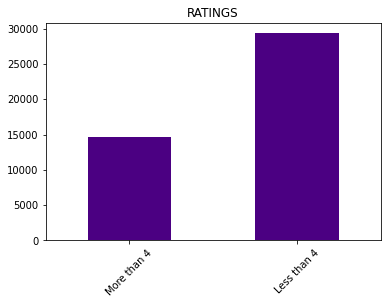

In [8]:
df['rate'][df['rate']>=str(4.0)].count()
df['rate'][df['rate']<=str(4.0)].count()
rating_df = pd.DataFrame([df['rate'][df['rate']>=str(4.0)].count(), df['rate'][df['rate']<=str(4.0)].count()], index=['More than 4', 'Less than 4'], columns=['rating'])
rating_df.plot.bar(y='rating', legend=False, rot=45, title='RATINGS', color='indigo')

<AxesSubplot:title={'center':'MOST VOTED'}, xlabel='Restaurants', ylabel='No of Votes'>

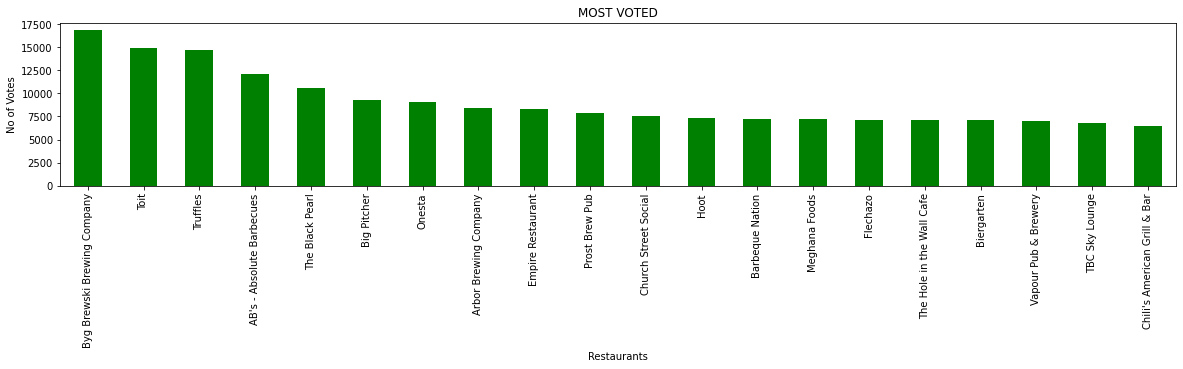

In [9]:
most_votesDF = df[['name', 'votes']].sort_values(by='votes', ascending=False)
most_votesDF.drop_duplicates(inplace=True, subset='name')
most_votesDF = most_votesDF.head(20)
most_votesDF.plot.bar(y='votes',x='name', ylabel='No of Votes', xlabel='Restaurants', legend=False, figsize=(20,3), title="MOST VOTED", color='green')

In [10]:
most_votesDF = most_votesDF.sample(frac=1)
most_votesDF_name = most_votesDF['name'].tolist()
most_votesDF_votes = most_votesDF['votes'].tolist()

fig = go.Figure()

fig.add_trace(go.Barpolar(
    r=list(most_votesDF_votes),
    theta=list(most_votesDF_name),
    name='',
    marker_color='rgb(240,128,128)',
    marker_line_color='rgb(128,128,128)',
    hoverinfo=['all'],
    opacity=0.8
))

fig.update_layout(
    title='RESTAURANTS WITH MOST VOTES',
    font_size=12,
    legend_font_size=15,
    polar_angularaxis_rotation=90,
    width=600,
    height=600,
    polar=dict(
        bgcolor="rgb(224,224,224)"
    )
)

fig.show()

In [11]:
# Cleaning the price row 
    
try:
    df['approx_cost(for two people)'] = df['approx_cost(for two people)'].str.replace(',','')
    df['approx_cost(for two people)'] = pd.to_numeric(df['approx_cost(for two people)'])
except:
    pass

In [12]:
# finding average cost of dining in different localities

locDf = df
locations = locDf['listed_in(city)'].unique()
avgPriceDic = dict()

for i in locations:
    tempDf = locDf[locDf['listed_in(city)']==i]
    priceMean = tempDf['approx_cost(for two people)'].mean()
    priceMean = float(priceMean)
    avgPriceDic[i] = priceMean

costDF = pd.DataFrame({'locality': list(avgPriceDic.keys()), 'cost': list(avgPriceDic.values())}, columns=['locality', 'cost'])
costDF

,locality,cost
0,Banashankari,401.551564
1,Bannerghatta Road,452.534077
2,Basavanagudi,445.137549
3,Bellandur,551.098361
4,Brigade Road,767.091115
5,Brookefield,521.246702
6,BTM,495.485145
7,Church Street,771.990104
8,Electronic City,496.955102
9,Frazer Town,558.237288


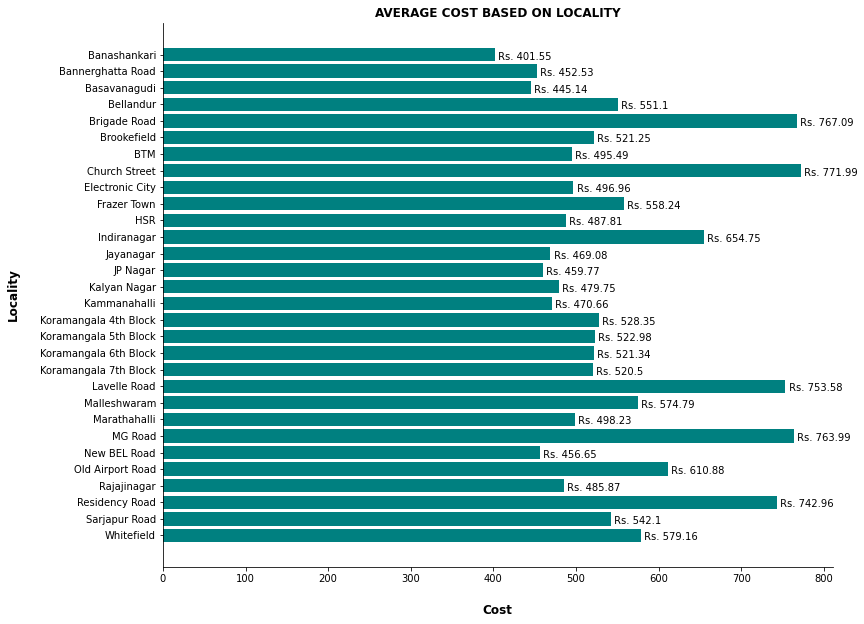

In [13]:
keys = list(avgPriceDic.keys())
values = list(avgPriceDic.values())

fig, ax = plt.subplots(figsize =(12, 10)) 
ax.barh(keys, values, color='teal')

for s in ['top', 'right']: 
    ax.spines[s].set_visible(False) 

ax.invert_yaxis() 
for i in ax.patches: 
    plt.text(i.get_width()+0.1, i.get_y()+0.7, ' Rs. '+str(round((i.get_width()), 2)), fontsize = 10, color ='black') 

ax.set_title('AVERAGE COST BASED ON LOCALITY',loc ='center', fontweight='bold') 
ax.set_ylabel("Locality", labelpad=20, weight='bold', size=12)
ax.set_xlabel("Cost", labelpad=20, weight='bold', size=12)
plt.show()

# MODEL

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [17]:
class Model:
    def __init__(self):
        # Constructor for the class
        self.df = pd.read_csv('zomato.csv')

        # For dropping the unnamed column
        self.df.drop(self.df.filter(regex="Unname"),axis=1, inplace=True)

        # Getting the X and Y training data
        self.X = pd.get_dummies(self.df[['location','cuisines','rest_type']],drop_first=True)
        # self.tempX = self.df.join(self.tempX)
        self.Y = pd.DataFrame(self.df['cost']).astype(int)
    
    # Method to create the model
    def create_model(self, req_value):
        dtree = DecisionTreeClassifier()

        """
        new_value = self.df.head(1)
        print(new_value)
        new_value.loc['0','location'] = req_value['location']
        new_value.loc['0','cuisines'] = req_value['cuisines']
        new_value.loc['0','rest_type'] = req_value['rest_type']
        new_value.loc['0']
        """

        self.new_df = self.df.append(new_row,ignore_index=True)

        self.testX = pd.get_dummies(self.new_df[['location','cuisines','rest_type']],drop_first=True)

        # X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size = 0.5, random_state = 0)

        # Fitting the entire model
        dtree.fit(self.X, self.Y)


        # Predicting the value
        self.dfres = dtree.predict(self.testX)
        self.score = accuracy_score(self.Y, self.dfres[:-1])
        print("Accuracy: ", self.score*100)

        self.res = self.dfres[-1]

        return self.res



In [18]:
# Testing the entire code
# Table columns names
# 0,address,name,online_order,book_table,rate,votes,location,rest_type,cuisines,cost,menu_item,listed_in(city)

new_row = {'address': '', 'name': '', 'online_order': '', 'book_table': '', 'rate': '', 'votes': '', 'location': 'Banashankari', 'rest_type': 'Quick Bites', 'cuisines': 'South Indian','cost': '', 'menu_item': '', 'listed_in': ''}
o = Model()

# check = new_df.join(mytemp)
temp = o.create_model(new_row)

print(temp)

Accuracy:  81.85038373956313
150
